## Loading the important Libraries

In [1]:
import csv
import math
import matplotlib.pyplot as plt
import numpy as np
import random
import re
from collections import defaultdict
from data.scorer import score_submission, print_confusion_matrix, score_defaults, SCORE_REPORT
from nltk import word_tokenize
from nltk.corpus import stopwords
from tqdm import tqdm
from sklearn.metrics import accuracy_score

# Loading the contents

In [2]:
f_bodies = open('data/train_bodies.csv', 'r', encoding='utf-8')
csv_bodies = csv.DictReader(f_bodies)
bodies = []
for row in csv_bodies:
    body_id = int(row['Body ID'])
    if (body_id + 1) > len(bodies):
        bodies += [None] * (body_id + 1 - len(bodies))
    bodies[body_id] = row['articleBody']
f_bodies.close()
body_inverse_index = {bodies[i]: i for i in range(len(bodies))}

all_unrelated, all_discuss, all_agree, all_disagree = [], [], [], []  # each article = (headline, body, stance)

f_stances = open('data/train_stances.csv', 'r', encoding='utf-8')
csv_stances = csv.DictReader(f_stances)
for row in csv_stances:
    body = bodies[int(row['Body ID'])]
    if row['Stance'] == 'unrelated':
        all_unrelated.append((row['Headline'], body, row['Stance']))
    elif row['Stance'] == 'discuss':
        all_discuss.append((row['Headline'], body, row['Stance']))
    elif row['Stance'] == 'agree':
        all_agree.append((row['Headline'], body, row['Stance']))
    elif row['Stance'] == 'disagree':
        all_disagree.append((row['Headline'], body, row['Stance']))
f_stances.close()

In [3]:
# Split to train and validation 9:1
print('\tUnrltd\tDiscuss\t Agree\tDisagree')
print('All\t', len(all_unrelated), '\t', len(all_discuss), '\t', len(all_agree), '\t', len(all_disagree))
all_unrelated=all_unrelated[:len(all_unrelated)//10]
all_discuss=all_discuss[:len(all_discuss)//10]
all_agree=all_agree[:len(all_agree)//10]
all_disagree=all_disagree[:len(all_disagree)//10]
print('\tUnrltd\tDiscuss\t Agree\tDisagree')
print('All\t', len(all_unrelated), '\t', len(all_discuss), '\t', len(all_agree), '\t', len(all_disagree))

	Unrltd	Discuss	 Agree	Disagree
All	 36545 	 8909 	 3678 	 840
	Unrltd	Discuss	 Agree	Disagree
All	 3654 	 890 	 367 	 84


In [4]:

train_unrelated = all_unrelated[:len(all_unrelated) * 9 // 10]
train_discuss = all_discuss[:len(all_discuss) * 9 // 10]
train_agree = all_agree[:len(all_agree) * 9 // 10]
train_disagree = all_disagree[:len(all_disagree) * 9 // 10]

val_unrelated = all_unrelated[len(all_unrelated) * 9 // 10:]
val_discuss = all_discuss[len(all_discuss) * 9 // 10:]
val_agree = all_agree[len(all_agree) * 9 // 10:]
val_disagree = all_disagree[len(all_disagree) * 9 // 10:]

print('Train\t', len(train_unrelated), '\t', len(train_discuss), '\t', len(train_agree), '\t', len(train_disagree))
print('Valid.\t', len(val_unrelated), '\t', len(val_discuss), '\t', len(val_agree), '\t', len(val_disagree))

Train	 3288 	 801 	 330 	 75
Valid.	 366 	 89 	 37 	 9


# Uniform distribution of Data

In [5]:
train_all = train_unrelated + train_discuss + train_agree + train_disagree
# each article = (headline, body, stance)
random.Random(0).shuffle(train_all)
train_all = np.array(train_all)

val_all = val_unrelated + val_discuss + val_agree + val_disagree
random.Random(0).shuffle(val_all)
val_all = np.array(val_all)

print('Train (Total)', train_all.shape, '\tValidation (Total)', val_all.shape)
print(np.count_nonzero(train_all[:, 2] == 'unrelated'), '\t',
      np.count_nonzero(train_all[:, 2] == 'discuss'), '\t',
      np.count_nonzero(train_all[:, 2] == 'agree'), '\t',
      np.count_nonzero(train_all[:, 2] == 'disagree'))
print(np.count_nonzero(val_all[:, 2] == 'unrelated'), '\t',
      np.count_nonzero(val_all[:, 2] == 'discuss'), '\t',
      np.count_nonzero(val_all[:, 2] == 'agree'), '\t',
      np.count_nonzero(val_all[:, 2] == 'disagree'))

Train (Total) (4494, 3) 	Validation (Total) (501, 3)
3288 	 801 	 330 	 75
366 	 89 	 37 	 9


In [6]:
# Tokenise text
pattern = re.compile("[^a-zA-Z0-9 ]+")  # strip punctuation, symbols, etc.
stop_words = set(stopwords.words('english'))
def tokenise(text):
    text = pattern.sub('', text.replace('\n', ' ').replace('-', ' ').lower())
    text = [word for word in word_tokenize(text) if word not in stop_words]
    return text

for i in range(9):
    print(train_all[i, 0], tokenise(train_all[i, 0]))

80's Brat Pack star Judd Nelson forced to deny that he's dead after fake news story starts trending on social media ['80s', 'brat', 'pack', 'star', 'judd', 'nelson', 'forced', 'deny', 'hes', 'dead', 'fake', 'news', 'story', 'starts', 'trending', 'social', 'media']
ISIS Executioner 'Jihadi John' Is Named as Mohammed Emwazi ['isis', 'executioner', 'jihadi', 'john', 'named', 'mohammed', 'emwazi']
Spider Burrows Into Australian Man's Appendix Scar (VIDEO) ['spider', 'burrows', 'australian', 'mans', 'appendix', 'scar', 'video']
Wife, child of Islamic State head Abu Bakr al-Baghdadi held in Lebanon, officials say ['wife', 'child', 'islamic', 'state', 'head', 'abu', 'bakr', 'al', 'baghdadi', 'held', 'lebanon', 'officials', 'say']
Sadly, Pumpkin Spice Condoms Aren't A Thing After All ['sadly', 'pumpkin', 'spice', 'condoms', 'arent', 'thing']
Woman detained in Lebanon is not al-Baghdadi's wife, Iraq says ['woman', 'detained', 'lebanon', 'al', 'baghdadis', 'wife', 'iraq', 'says']
Wildest Apple W

In [7]:
# Compute term-frequency of words in documents
def doc_to_tf(text, ngram=1):
    words = tokenise(text)
    ret = defaultdict(float)
    for i in range(len(words)):
        for j in range(1, ngram+1):
            if i - j < 0:
                break
            word = [words[i-k] for k in range(j)]
            ret[word[0] if ngram == 1 else tuple(word)] += 1.0
    return ret
    
for i in range(5):
    print(train_all[i, 0], doc_to_tf(train_all[i, 0]))
print(train_all[0, 0], doc_to_tf(train_all[0, 0], ngram=2))

80's Brat Pack star Judd Nelson forced to deny that he's dead after fake news story starts trending on social media defaultdict(<class 'float'>, {'brat': 1.0, 'pack': 1.0, 'star': 1.0, 'judd': 1.0, 'nelson': 1.0, 'forced': 1.0, 'deny': 1.0, 'hes': 1.0, 'dead': 1.0, 'fake': 1.0, 'news': 1.0, 'story': 1.0, 'starts': 1.0, 'trending': 1.0, 'social': 1.0, 'media': 1.0})
ISIS Executioner 'Jihadi John' Is Named as Mohammed Emwazi defaultdict(<class 'float'>, {'executioner': 1.0, 'jihadi': 1.0, 'john': 1.0, 'named': 1.0, 'mohammed': 1.0, 'emwazi': 1.0})
Spider Burrows Into Australian Man's Appendix Scar (VIDEO) defaultdict(<class 'float'>, {'burrows': 1.0, 'australian': 1.0, 'mans': 1.0, 'appendix': 1.0, 'scar': 1.0, 'video': 1.0})
Wife, child of Islamic State head Abu Bakr al-Baghdadi held in Lebanon, officials say defaultdict(<class 'float'>, {'child': 1.0, 'islamic': 1.0, 'state': 1.0, 'head': 1.0, 'abu': 1.0, 'bakr': 1.0, 'al': 1.0, 'baghdadi': 1.0, 'held': 1.0, 'lebanon': 1.0, 'officials'

In [8]:
# Build corpus of article bodies and headlines in training dataset
corpus = np.r_[train_all[:, 1], train_all[:, 0]]  # 0 to 44973 are bodies, 44974 to 89943 are headlines

print(corpus[44974//10])
print(corpus[0])

Wife, child of Islamic State head Abu Bakr al-Baghdadi held in Lebanon, officials say
New Delhi: AK Verma, an executive engineer at the Central Public Works Department, was fired after last appearing for work in December 1990.
"He went on seeking extension of leave, which was not sanctioned, and defied directions to report to work," the government said in a statement on Thursday.
Even after an inquiry found him guilty of "wilful absence from duty" in 1992, it took another 22 years and the intervention of a cabinet minister to remove him, the government said.
Government fires employee who skipped work for 24 years
AK Verma, an executive engineer at the Central Public Works Department, was fired after last appearing for work in December 1990.
#india #government job #ak verma #absence
India's labour laws, which the World Bank says are the most restrictive anywhere, make it hard to sack staff for any reason other than criminal misconduct.
States, led by Rajasthan and Madhya Pradesh, have r

In [9]:
# Learn idf of every word in the corpus
df = defaultdict(float)
for doc in tqdm(corpus):
    words = tokenise(doc)
    seen = set()
    for word in words:
        if word not in seen:
            df[word] += 1.0
            seen.add(word)

print(list(df.items())[:10])

100%|██████████| 8988/8988 [00:10<00:00, 834.38it/s] 

[('new', 1597.0), ('delhi', 31.0), ('ak', 23.0), ('verma', 33.0), ('executive', 135.0), ('engineer', 45.0), ('central', 221.0), ('public', 570.0), ('works', 111.0), ('department', 390.0)]


In [10]:
num_docs = corpus.shape[0]
idf = defaultdict(float)
for word, val in tqdm(df.items()):
    idf[word] = np.log((1.0 + num_docs) / (1.0 + val)) + 1.0  # smoothed idf

print(list(idf.items())[:10])

100%|██████████| 21414/21414 [00:00<00:00, 438914.48it/s]

[('new', 2.7272487602471793), ('delhi', 6.638020983773672), ('ak', 6.925703056225454), ('verma', 6.577396361957238), ('executive', 5.191102000837347), ('engineer', 6.275115490084304), ('central', 4.70107950470112), ('public', 3.756367676917389), ('works', 5.385258015278304), ('department', 4.1350493265880335)]


In [11]:
# Load GLoVe word vectors
f_glove = open("data/glove.6B.50d.txt", "rb")  # download from https://nlp.stanford.edu/projects/glove/
glove_vectors = {}
for line in tqdm(f_glove):
    glove_vectors[str(line.split()[0]).split("'")[1]] = np.array(list(map(float, line.split()[1:])))

print(glove_vectors['glove'])

400000it [00:08, 48173.29it/s]

[-1.2879   -0.14538  -0.016613  1.1387    1.1317    0.20705  -0.47351
  0.15898   0.67879   0.2382    0.11621   0.26053  -0.8379    1.1232
  0.31469  -0.47904  -0.33717  -0.34492  -0.72053  -1.0543   -0.58476
 -0.42184  -0.56977  -1.1697   -0.50389  -1.4706   -0.22005   1.1314
  1.0829   -1.5477    0.77931  -0.22865   0.33369   0.52067   0.22109
  1.1267    0.11704   1.1647    0.5875   -0.079243  0.022386  0.90118
 -0.37459   0.82637  -0.41061  -0.95039   0.44121  -0.58558   0.12594
 -0.71778 ]


In [12]:
# Convert a document to GloVe vectors, by computing tf-idf of each word * GLoVe of word / total tf-idf for document
def doc_to_glove(doc):
    doc_tf = doc_to_tf(doc)
    doc_tf_idf = defaultdict(float)
    for word, tf in doc_tf.items():
        doc_tf_idf[word] = tf * idf[word]
        
    doc_vector = np.zeros(glove_vectors['glove'].shape[0])
    if np.sum(list(doc_tf_idf.values())) == 0.0:  # edge case: document is empty
        return doc_vector
    
    for word, tf_idf in doc_tf_idf.items():
        if word in glove_vectors:
            doc_vector += glove_vectors[word] * tf_idf
    doc_vector /= np.sum(list(doc_tf_idf.values()))
    return doc_vector

for i in range(2):
    print(train_all[i, 0], doc_to_glove(train_all[i, 0]))

80's Brat Pack star Judd Nelson forced to deny that he's dead after fake news story starts trending on social media [-0.04232922 -0.01842568  0.34725012 -0.05143704 -0.02753592  0.1682777
 -0.45394914 -0.20182683 -0.06393099  0.12318077 -0.21048225 -0.02127707
 -0.28266516  0.06272534  0.36039735 -0.08274542 -0.01398294  0.14213195
 -0.11515137 -0.0542858  -0.22879347  0.24957358  0.27535965  0.28703066
  0.27818191 -0.9612341  -0.15123584  0.04693107  0.0870427  -0.20253248
  1.58425465  0.14010385 -0.16811974 -0.06777901 -0.05983563  0.11708822
 -0.10178175 -0.1090852  -0.06097973 -0.3190436   0.00921121  0.24765028
 -0.2795602   0.02881755 -0.01448855 -0.13076779  0.06523218 -0.16874656
  0.08062678  0.07997211]
ISIS Executioner 'Jihadi John' Is Named as Mohammed Emwazi [-0.07901437  0.02569246 -0.00914783 -0.25959812  0.82608616 -0.34248026
 -0.15879729 -0.04972512  0.18958255 -0.06482656  0.05285636  0.41382386
 -0.39589128  0.28481863  0.07249011 -0.16184485  0.01960323 -0.059741

In [13]:
# Compute cosine similarity of GLoVe vectors for all headline-body pairs
def dot_product(vec1, vec2):
    sigma = 0.0
    for i in range(vec1.shape[0]):  # assume vec1 and vec2 has same shape
        sigma += vec1[i] * vec2[i]
    return sigma
    
def magnitude(vec):
    return np.sqrt(np.sum(np.square(vec)))
        
def cosine_similarity(doc):
    headline_vector = doc_to_glove(doc[0])
    body_vector = doc_to_glove(doc[1])
    
    if magnitude(headline_vector) == 0.0 or magnitude(body_vector) == 0.0:  # edge case: document is empty
        return 0.0
    
    return dot_product(headline_vector, body_vector) / (magnitude(headline_vector) * magnitude(body_vector))

for i in range(10):
    # unrelated should have lower than rest
    print(cosine_similarity(train_all[i]), train_all[i, 2])
print(cosine_similarity(train_all[27069//10]), tokenise(train_all[27069//10, 0]), tokenise(train_all[27069//10, 1]))  # edge case

0.7796294972801269 unrelated
0.6696348647387658 discuss
0.6400303845756461 agree
0.9198332035953785 discuss
0.7104113473477834 agree
0.6098851525838833 unrelated
0.6343919054331733 unrelated
0.8080645651019855 unrelated
0.6535276154267927 unrelated
0.6848027592116739 unrelated
0.6195285187185433 ['emotional', 'sergeant', 'arms', 'greeted', 'back', 'parliament', 'rousing', 'standing', 'ovation', 'day', 'heroically', 'shot', 'dead', 'terrorist', 'first', 'time', 'used', 'weapon', '30', 'year', 'career'] ['vice', 'founder', 'shane', 'smith', 'something', 'caviar', 'via', 'twittercom', 'bloomberg', 'reported', 'wednesday', 'vice', 'founder', 'shane', 'smith', 'recently', 'balled', 'exceptionally', 'hard', 'dinner', 'group', '12', 'prime', 'steakhouse', 'las', 'vegas', 'racking', '300000', 'check', 'source', 'vice', 'told', 'buzzfeed', 'news', 'smith', 'sum', 'well', 'north', 'bill', 'gambling', 'week', 'ces', 'conference', 'las', 'vegas', 'paid', 'dinner', 'personal', 'credit', 'card', 'fi

In [14]:
# Compute the KL-Divergence of language model (LM) representations of the headline and the body
def divergence(lm1, lm2):
    sigma = 0.0
    for i in range(lm1.shape[0]):  # assume lm1 and lm2 has same shape
        sigma += lm1[i] * np.log(lm1[i] / lm2[i])
    return sigma

def kl_divergence(doc, eps=0.1):
    # Convert headline and body to 1-gram representations
    tf_headline = doc_to_tf(doc[0])
    tf_body = doc_to_tf(doc[1])
    
    # Convert dictionary tf representations to vectors (make sure columns match to the same word)
    words = set(tf_headline.keys()).union(set(tf_body.keys()))
    vec_headline, vec_body = np.zeros(len(words)), np.zeros(len(words))
    i = 0
    for word in words:
        vec_headline[i] += tf_headline[word]
        vec_body[i] = tf_body[word]
        i += 1
    
    # Compute a simple 1-gram language model of headline and body
    lm_headline = vec_headline + eps
    lm_headline /= np.sum(lm_headline)
    lm_body = vec_body + eps
    lm_body /= np.sum(lm_body)
    
    # Return KL-divergence of both language models
    return divergence(lm_headline, lm_body)

for i in range(10):
    # unrelated should have higher than rest
    print(kl_divergence(train_all[i]), train_all[i, 2])
print(kl_divergence(train_all[27069//10]), tokenise(train_all[27069//10, 0]), tokenise(train_all[27069//10, 1]))  # edge case

2.226440047423417 unrelated
0.2329880699498739 discuss
1.0954376779526533 agree
1.112234431366886 discuss
0.24539173771114703 agree
1.7203908550549427 unrelated
1.7552125109890526 unrelated
1.2189288365130526 unrelated
1.9714975844932492 unrelated
1.0642521299178045 unrelated
1.3503533061417534 ['emotional', 'sergeant', 'arms', 'greeted', 'back', 'parliament', 'rousing', 'standing', 'ovation', 'day', 'heroically', 'shot', 'dead', 'terrorist', 'first', 'time', 'used', 'weapon', '30', 'year', 'career'] ['vice', 'founder', 'shane', 'smith', 'something', 'caviar', 'via', 'twittercom', 'bloomberg', 'reported', 'wednesday', 'vice', 'founder', 'shane', 'smith', 'recently', 'balled', 'exceptionally', 'hard', 'dinner', 'group', '12', 'prime', 'steakhouse', 'las', 'vegas', 'racking', '300000', 'check', 'source', 'vice', 'told', 'buzzfeed', 'news', 'smith', 'sum', 'well', 'north', 'bill', 'gambling', 'week', 'ces', 'conference', 'las', 'vegas', 'paid', 'dinner', 'personal', 'credit', 'card', 'fin

In [15]:
# Other feature 1
def ngram_overlap(doc):
    # Returns how many times n-grams (up to 3-gram) that occur in the article's headline occur on the article's body.
    tf_headline = doc_to_tf(doc[0], ngram=3)
    tf_body = doc_to_tf(doc[1], ngram=3)
    matches = 0.0
    for words in tf_headline.keys():
        if words in tf_body:
            matches += tf_body[words]
    return np.power((matches / len(tokenise(doc[1]))), 1 / np.e)  # normalise for document length

for i in range(10):
    # unrelated should have lower than rest
    print(ngram_overlap(train_all[i]), train_all[i, 2])

0.0 unrelated
0.42340515458067857 discuss
0.2665034867244887 agree
0.5882381732700303 discuss
0.616306765353032 agree
0.0 unrelated
0.0 unrelated
0.13680655892255053 unrelated
0.21780086698519668 unrelated
0.11553832447351613 unrelated


In [16]:
# Define function to convert (headline, body) to feature vectors for each document
ftrs = [cosine_similarity, kl_divergence, ngram_overlap]
def to_feature_array(doc):
    vec = np.array([0.0] * len(ftrs))
    for i in range(len(ftrs)):
        vec[i] = ftrs[i](doc)
    return vec

# Initialise X (matrix of feature vectors) for train dataset
x_train = np.array([to_feature_array(doc) for doc in tqdm(train_all)])
print(x_train[:10])

100%|██████████| 4494/4494 [00:49<00:00, 91.24it/s] 

[[0.7796295  2.22644005 0.        ]
 [0.66963486 0.23298807 0.42340515]
 [0.64003038 1.09543768 0.26650349]
 [0.9198332  1.11223443 0.58823817]
 [0.71041135 0.24539174 0.61630677]
 [0.60988515 1.72039086 0.        ]
 [0.63439191 1.75521251 0.        ]
 [0.80806457 1.21892884 0.13680656]
 [0.65352762 1.97149758 0.21780087]
 [0.68480276 1.06425213 0.11553832]]


In [17]:
# Define label <-> int mappings for y
label_to_int = {'agree': 0, 'disagree': 1, 'discuss': 2, 'unrelated': 3}
int_to_label = ['agree', 'disagree', 'discuss', 'unrelated']

# Initialise Y (gold output vector) for train dataset
y_train = np.array([label_to_int[i] for i in train_all[:, 2]])
print(y_train[:10])

[3 2 0 2 0 3 3 3 3 3]


In [18]:
# Check integrity of X and Y
print(np.where(np.isnan(x_train)))
print(np.where(np.isfinite(x_train) == False))
print(x_train.shape)
print(y_train.shape)  # x_train.shape[0] == y_train.shape[0]

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(4494, 3)
(4494,)


[('g', 'agree'), ('r', 'disagree'), ('b', 'discuss'), ('y', 'unrelated')]


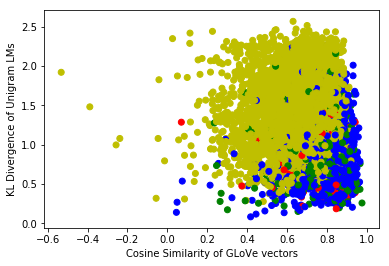

In [19]:
# Plot GLoVe distance vs KL-Divergence on a coloured scatter plot with different colours for each label
colours = np.array(['g', 'r', 'b', 'y'])
plt.scatter(list(x_train[:, 0]), list(x_train[:, 1]), c=colours[y_train])
plt.xlabel('Cosine Similarity of GLoVe vectors')
plt.ylabel('KL Divergence of Unigram LMs')
print([(colours[i], int_to_label[i]) for i in range(len(int_to_label))])
plt.show()

In [20]:
# Initialise x (feature vectors) for validation dataset
x_val = np.array([to_feature_array(doc) for doc in tqdm(val_all)])
print(x_val[:5])

100%|██████████| 501/501 [00:05<00:00, 88.63it/s] 

[[0.92415851 0.62881781 0.22284315]
 [0.70244366 0.86754189 0.43404718]
 [0.72377623 1.65128671 0.        ]
 [0.69761169 0.39372154 0.37469461]
 [0.78924781 0.23513214 0.34531151]]


In [21]:
# Linear regression model
def mse(pred, gold):
    sigma = 0.0
    for i in range(pred.shape[0]):
        sigma += np.square(pred[i] - gold[i])
    return sigma / (2 * pred.shape[0])

print(mse(np.array([0.0, 0.2, 0.5, 0.5, 0.8, 1.0]), np.array([0, 0, 0, 1, 1, 1])))

0.04833333333333334


In [22]:
class LinearRegression:
    
    def __init__(self, lrn_rate, n_iter):
        self.lrn_rate = lrn_rate
        self.n_iter = n_iter
        # self.breakpoints = set([n_iter * i // 10 for i in range(1, 11)])
        
    def fit(self, X, Y):
        # Learn a model y = intercept + x0*t0 + x1*t1 + x2*t2 + ... that minimises MSE. Need to optimise T
        # self.intercept = 0.0
        self.model = np.zeros(X.shape[1])  # model[0] = t0, model[1] = t1, etc.
        for it in tqdm(range(self.n_iter)):
            model_Y = self.transform(X)
            # Thetas
            for col in range(X.shape[1]):
                s = 0.0
                for row in range(X.shape[0]):
                    s += (model_Y[row] - Y[row]) * X[row, col]
                self.model[col] -= self.lrn_rate * s / X.shape[0]
            # Intercept
            # s_int = 0.0
            # for row in range(X.shape[0]):
            #     s_int += (model_Y[row] - Y[row]) * 1.0
            # self.intercept -= self.lrn_rate * s_int / X.shape[0]
            # if it + 1 in self.breakpoints:
                # print('Iteration', it+1, 'MSE:', mse(model_Y, Y))
        print('Final MSE:', mse(model_Y, Y))
        # print('Intercept:', self.intercept)
        print('Model:', self.model)
        
    def transform(self, X):
        # Returns a float value for each X. (Regression)
        Y = np.zeros(X.shape[0])
        for row in range(X.shape[0]):
            # s = self.intercept
            s = 0.0
            for col in range(X.shape[1]):
                s += self.model[col] * X[row, col]
            Y[row] = s
        return Y
    
    def predict(self, X):
        # Uses results of transform() for binary classification. For testing only, use OneVAllClassifier for the final run.
        Y = self.transform(X)
        Y = np.array([(1 if i > 0.5 else 0) for i in Y])
        return Y

# Test only
lr = LinearRegression(lrn_rate=0.1, n_iter=100)
lr.fit(x_train[:1000], np.array([(1 if i == 3 else 0) for i in y_train[:1000]]))
print(lr.transform(x_train[1000:1020]))
print('Predicted', lr.predict(x_train[1000:1020]))
print('Actual', np.array([(1 if i == 3 else 0) for i in y_train[1000:1020]]))

100%|██████████| 100/100 [00:00<00:00, 264.47it/s]

Final MSE: 0.05806494732550978
Model: [ 0.08728049  0.54466373 -0.32499452]
[0.35166402 1.130639   0.61526072 0.3761945  1.27067938 1.3655792
 0.22475605 0.94118786 1.10233257 0.32345234 1.24320873 0.13535789
 1.2728668  1.04154892 0.6305938  0.20693177 0.66185312 0.73889816
 0.91187797 0.21373834]
Predicted [0 1 1 0 1 1 0 1 1 0 1 0 1 1 1 0 1 1 1 0]
Actual [0 1 1 0 1 1 0 1 1 0 1 0 1 1 1 0 1 1 1 0]


In [23]:
# Logistic regression functions
def sigmoid(Y):
    return 1 / (1 + np.exp(Y * -1))

print(sigmoid(np.array([0.0, 0.2, 0.5, 0.5, 0.8, 1.0])))

def logistic_cost(pred, gold):
    sigma = 0.0
    for i in range(pred.shape[0]):
        if gold[i] == 1:  
            sigma -= np.log(pred[i])
        elif gold[i] == 0:
            sigma -= np.log(1 - pred[i])
    return sigma / pred.shape[0]

print(mse(np.array([0.0, 0.2, 0.5, 0.5, 0.8, 1.0]), np.array([0, 0, 0, 1, 1, 1])))
print(logistic_cost(np.array([0.0, 0.2, 0.5, 0.5, 0.8, 1.0]), np.array([0, 0, 0, 1, 1, 1])))
print(logistic_cost(sigmoid(np.array([0.0, 0.2, 0.5, 0.5, 0.8, 1.0])), np.array([0, 0, 0, 1, 1, 1])))

[0.5        0.549834   0.62245933 0.62245933 0.68997448 0.73105858]
0.04833333333333334
0.3054302439580517
0.6039670619612919


In [24]:
# Logistic regression model
class LogisticRegression:
    
    def __init__(self, lrn_rate, n_iter):
        self.lrn_rate = lrn_rate
        self.n_iter = n_iter
        # self.breakpoints = set([n_iter * i // 10 for i in range(1, 11)])
        
    def fit(self, X, Y):
        # Learn a model y = x0*t0 + x1*t1 + x2*t2 + ... that minimises MSE. Need to optimise T
        self.model = np.zeros(X.shape[1])  # model[0] = t0, model[1] = t1, etc.
        for it in tqdm(range(self.n_iter)):
            model_Y = self.transform(X)
            for col in range(X.shape[1]):
                s = 0.0
                for row in range(X.shape[0]):
                    s += (model_Y[row] - Y[row]) * X[row, col]
                self.model[col] -= self.lrn_rate * s / X.shape[0]
            # if it + 1 in self.breakpoints:
                # print('Iteration', it+1, 'loss:', logistic_cost(model_Y, Y))
        print('Final loss:', logistic_cost(model_Y, Y))
        print('Model:', self.model)
        
    def transform(self, X):
        # Returns a float value for each X. (Regression)
        Y = np.zeros(X.shape[0])
        for row in range(X.shape[0]):
            s = 0.0
            for col in range(X.shape[1]):
                s += self.model[col] * X[row, col]
            Y[row] = s
        return sigmoid(Y)
    
    def predict(self, X):
        # Uses results of transform() for binary classification. For testing only, use OneVAllClassifier for the final run.
        Y = self.transform(X)
        Y = np.array([(1 if i > 0.5 else 0) for i in Y])
        return Y

# Test only
lr = LogisticRegression(lrn_rate=0.1, n_iter=100)
lr.fit(x_train[:1000], np.array([(1 if i == 3 else 0) for i in y_train[:1000]]))
print(lr.transform(x_train[1000:1020]))
print('Predicted', lr.predict(x_train[1000:1020]))
print('Actual', np.array([(1 if i == 3 else 0) for i in y_train[1000:1020]]))

100%|██████████| 100/100 [00:00<00:00, 264.08it/s]

Final loss: 0.4385336869319177
Model: [-0.13242509  1.1160697  -0.53844582]
[0.62145479 0.89084852 0.74059812 0.64167996 0.91945955 0.92894078
 0.55464769 0.84768932 0.88764478 0.61804963 0.91302421 0.53214858
 0.91921343 0.87053464 0.74445084 0.54891988 0.74854143 0.80257594
 0.83893607 0.58064085]
Predicted [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Actual [0 1 1 0 1 1 0 1 1 0 1 0 1 1 1 0 1 1 1 0]


In [25]:
# To use linear/logistic regression models to classify multiple classes
class OneVAllClassifier:
    
    def __init__(self, regression, **params):
        self.regression = regression
        self.params = params
        
    def fit(self, X, Y):
        # Learn a model for each parameter.
        self.categories = np.unique(Y)
        self.models = {}
        for cat in self.categories:
            ova_Y = np.array([(1 if i == cat else 0) for i in Y])
            model = self.regression(**self.params)
            model.fit(X, ova_Y)
            self.models[cat] = model
            print(int_to_label[cat])
    
    def predict(self, X):
        # Predicts each x for each different model learned, and returns the category related to the model with the highest score.
        vals = {}
        for cat, model in self.models.items():
            vals[cat] = model.transform(X)
        Y = np.zeros(X.shape[0], dtype=np.int)
        for row in range(X.shape[0]):
            max_val, max_cat = -math.inf, -math.inf
            for cat, val in vals.items():
                if val[row] > max_val:
                    max_val, max_cat = val[row], cat
            Y[row] = max_cat
        return Y
    
# Test only
ova = OneVAllClassifier(LinearRegression, lrn_rate=0.1, n_iter=100)
ova.fit(x_train[:1000], y_train[:1000])
print('Predicted', ova.predict(x_train[1000:1020]))
print('Actual', y_train[1000:1020])

 61%|██████    | 61/100 [00:00<00:00, 302.57it/s]

Final MSE: 0.03137935014302291
Model: [ 0.15773999 -0.046042    0.18115527]
agree


 57%|█████▋    | 57/100 [00:00<00:00, 281.52it/s]

Final MSE: 0.007285404583131371
Model: [ 0.02443375 -0.00657916  0.02998626]
disagree


 56%|█████▌    | 56/100 [00:00<00:00, 280.65it/s]

Final MSE: 0.04992407240395495
Model: [ 0.35673448 -0.11027682  0.34445118]
discuss


100%|██████████| 100/100 [00:00<00:00, 285.80it/s]

Final MSE: 0.05806494732550978
Model: [ 0.08728049  0.54466373 -0.32499452]
unrelated
Predicted [2 3 3 3 3 3 2 3 3 3 3 2 3 3 3 2 3 3 3 2]
Actual [2 3 3 0 3 3 2 3 3 1 3 2 3 3 3 2 3 3 3 0]


In [26]:
# Train the linear regression & One-V-All classifier models on the train set
clf = OneVAllClassifier(LinearRegression, lrn_rate=0.1, n_iter=1000)
clf.fit(x_train, y_train)

  1%|          | 7/1000 [00:00<00:15, 63.83it/s]

Final MSE: 0.029136027309288486
Model: [ 0.06940905 -0.03053299  0.43887671]
agree


  1%|          | 6/1000 [00:00<00:16, 59.41it/s]

Final MSE: 0.007976384853805911
Model: [ 0.02335813 -0.01003328  0.08832855]
disagree


  1%|          | 6/1000 [00:00<00:16, 58.49it/s]

Final MSE: 0.042923676201832524
Model: [ 0.29008514 -0.12641309  0.9632514 ]
discuss


100%|██████████| 1000/1000 [00:15<00:00, 64.21it/s]

Final MSE: 0.04273193029869748
Model: [ 0.54891274  0.41154284 -1.36334332]
unrelated


In [27]:
# Predict y for validation set
y_pred = clf.predict(x_val)
print(y_pred[:5])
predicted = np.array([int_to_label[i] for i in y_pred])
print(predicted[:5])
print(val_all[:, 2][:5])

[3 2 3 2 2]
['unrelated' 'discuss' 'unrelated' 'discuss' 'discuss']
['discuss' 'agree' 'unrelated' 'discuss' 'discuss']


In [28]:
# Prepare validation dataset format for score_submission in scorer.py
body_ids = [str(body_inverse_index[body]) for body in val_all[:, 1]]
pred_for_cm = np.array([{'Headline': val_all[i, 0], 'Body ID': body_ids[i], 'Stance': predicted[i]} for i in range(len(val_all))])
gold_for_cm = np.array([{'Headline': val_all[i, 0], 'Body ID': body_ids[i], 'Stance': val_all[i, 2]} for i in range(len(val_all))])

In [29]:
# Score using scorer.py (provided in https://github.com/FakeNewsChallenge/fnc-1) on VALIDATION set:
test_score, cm = score_submission(gold_for_cm, pred_for_cm)
null_score, max_score = score_defaults(gold_for_cm)
print_confusion_matrix(cm)
print(SCORE_REPORT.format(max_score, null_score, test_score))

CONFUSION MATRIX:
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |     0     |     0     |    29     |     8     |
-------------------------------------------------------------
| disagree  |     0     |     0     |     4     |     5     |
-------------------------------------------------------------
|  discuss  |     0     |     0     |    74     |    15     |
-------------------------------------------------------------
| unrelated |     0     |     0     |     2     |    364    |
-------------------------------------------------------------
ACCURACY: 0.874

MAX  - the best possible score (100% accuracy)
NULL - score as if all predicted stances were unrelated
TEST - score based on the provided predictions

||    MAX    ||    NULL   ||    TEST   ||
||   226.5   ||   91.5    ||  173.25   ||



In [30]:
# Predict y for validation set using logistic regression instead of linear regression, and compare results of scorer.py
clf_logistic = OneVAllClassifier(LogisticRegression, lrn_rate=0.1, n_iter=1000)
clf_logistic.fit(x_train, y_train)

y_pred = clf_logistic.predict(x_val)
predicted = np.array([int_to_label[i] for i in y_pred])

body_ids = [str(body_inverse_index[body]) for body in val_all[:, 1]]
pred_for_cm = np.array([{'Headline': val_all[i, 0], 'Body ID': body_ids[i], 'Stance': predicted[i]} for i in range(len(val_all))])
gold_for_cm = np.array([{'Headline': val_all[i, 0], 'Body ID': body_ids[i], 'Stance': val_all[i, 2]} for i in range(len(val_all))])

test_score, cm = score_submission(gold_for_cm, pred_for_cm)
null_score, max_score = score_defaults(gold_for_cm)
print()
print_confusion_matrix(cm)
print(SCORE_REPORT.format(max_score, null_score, test_score))
# linear regression performs better, so that model is chosen for the test set

  1%|          | 7/1000 [00:00<00:16, 61.15it/s]

Final loss: 0.22767752910544284
Model: [-0.57304928 -2.09236266  0.87725516]
agree


  1%|          | 7/1000 [00:00<00:15, 62.98it/s]

Final loss: 0.08008250632684487
Model: [-1.61900747 -2.69372449 -0.23554629]
disagree


  1%|          | 6/1000 [00:00<00:17, 55.70it/s]

Final loss: 0.29937734200851823
Model: [ 0.88947324 -2.38670341  2.38026433]
discuss


100%|██████████| 1000/1000 [00:16<00:00, 61.79it/s]


Final loss: 0.2611590004848478
Model: [-1.78783368  2.57298046 -3.6742005 ]
unrelated

CONFUSION MATRIX:
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |     0     |     0     |    21     |    16     |
-------------------------------------------------------------
| disagree  |     0     |     0     |     3     |     6     |
-------------------------------------------------------------
|  discuss  |     0     |     0     |    60     |    29     |
-------------------------------------------------------------
| unrelated |     0     |     0     |     6     |    360    |
-------------------------------------------------------------
ACCURACY: 0.838

MAX  - the best possible score (100% accuracy)
NULL - score as if all predicted stances were unrelated
TEST - score based on the provided predictions

||    MAX    ||    NULL   ||    TEST   ||
|| 

In [31]:
# Load test data from CSV
f_tbodies = open('data/competition_test_bodies.csv', 'r', encoding='utf-8')
csv_tbodies = csv.DictReader(f_tbodies)
tbodies = []
for row in csv_tbodies:
    body_id = int(row['Body ID'])
    if (body_id + 1) > len(tbodies):
        tbodies += [None] * (body_id + 1 - len(tbodies))
    tbodies[body_id] = row['articleBody']
f_tbodies.close()
tbody_inverse_index = {tbodies[i]: i for i in range(len(tbodies))}

test_all = []  # each article = (headline, body, stance)

f_tstances = open('data/competition_test_stances.csv', 'r', encoding='utf-8')
csv_tstances = csv.DictReader(f_tstances)
for row in csv_tstances:
    body = tbodies[int(row['Body ID'])]
    test_all.append((row['Headline'], body, row['Stance']))
f_tstances.close()

#test_all = np.array(test_all)  # for some reason gives MemoryError
#print(test_all.shape)

In [32]:
# Initialise x (feature vectors) and y for test dataset
x_test = np.array([to_feature_array(doc) for doc in tqdm(test_all)])
print(x_test[:5])

100%|██████████| 25413/25413 [04:15<00:00, 99.35it/s] 


[[0.78758225 1.84940367 0.        ]
 [0.44744337 1.50340396 0.        ]
 [0.59893126 1.32746514 0.14596078]
 [0.5655158  1.17096374 0.        ]
 [0.73445991 2.1493695  0.        ]]


In [33]:
# Predict y for test set
y_test = clf.predict(x_test)
print(y_pred[:5])
pred_test = np.array([int_to_label[i] for i in y_test])
print(pred_test[:5])

[2 2 3 2 2]
['unrelated' 'unrelated' 'unrelated' 'unrelated' 'unrelated']


In [34]:
# Prepare test dataset format for score_submission in scorer.py
test_body_ids = [str(tbody_inverse_index[test_all[i][1]]) for i in range(len(test_all))]
test_pred_for_cm = np.array([{'Headline': test_all[i][0], 'Body ID': test_body_ids[i], 'Stance': pred_test[i]} for i in range(len(test_all))])
test_gold_for_cm = np.array([{'Headline': test_all[i][0], 'Body ID': test_body_ids[i], 'Stance': test_all[i][2]} for i in range(len(test_all))])

In [35]:
# Score using scorer.py (provided in https://github.com/FakeNewsChallenge/fnc-1) on TEST set:
test_score, cm = score_submission(test_gold_for_cm, test_pred_for_cm)
null_score, max_score = score_defaults(test_gold_for_cm)
print_confusion_matrix(cm)
print(SCORE_REPORT.format(max_score, null_score, test_score))

CONFUSION MATRIX:
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |     0     |     0     |   1513    |    390    |
-------------------------------------------------------------
| disagree  |     0     |     0     |    438    |    259    |
-------------------------------------------------------------
|  discuss  |     0     |     0     |   3435    |   1029    |
-------------------------------------------------------------
| unrelated |     1     |     0     |    162    |   18186   |
-------------------------------------------------------------
ACCURACY: 0.851

MAX  - the best possible score (100% accuracy)
NULL - score as if all predicted stances were unrelated
TEST - score based on the provided predictions

||    MAX    ||    NULL   ||    TEST   ||
|| 11651.25  ||  4587.25  ||  8469.25  ||



## Comparison Models

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier   
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.semi_supervised import LabelPropagation

classifiers=[
    (LogisticRegression(penalty='l1'),"Logistic Regression"),
    (KNeighborsClassifier(5),"K Nearest Classifier "),
    (SVC(),'Support Vector Machine Classifier'),
    (QuadraticDiscriminantAnalysis(),'Qudratic Discriminant Analysis'),
    (RandomForestClassifier(max_depth=50, n_estimators=10, max_features=1),'Random Forest Classifier'),
    (AdaBoostClassifier(),'Adaboost Classifier'),
    (SGDClassifier(),'SGD Classifier'),
    (DecisionTreeClassifier(max_depth=5),'Decision Tree Classifier'),
    (xgboost.XGBClassifier(learning_rate=0.1),'XG Boost Classifier'),
    (LinearDiscriminantAnalysis(),'Linear Discriminant Analysis'),
    (GaussianNB(),'Gaussian Naive Bayes '),
]

In [38]:
score=[];names=[]

for model,name in classifiers:
    clf=model.fit(x_train,y_train)
    y_pred=clf.predict(x_val)
    predicted = np.array([int_to_label[i] for i in y_pred])
    body_ids = [str(body_inverse_index[body]) for body in val_all[:, 1]]
    pred_for_cm = np.array([{'Headline': val_all[i, 0], 'Body ID': body_ids[i], 'Stance': predicted[i]} for i in range(len(val_all))])
    gold_for_cm = np.array([{'Headline': val_all[i, 0], 'Body ID': body_ids[i], 'Stance': val_all[i, 2]} for i in range(len(val_all))])
    
    test_score, cm = score_submission(gold_for_cm, pred_for_cm)
    null_score, max_score = score_defaults(gold_for_cm)
    print('*'*20);names.append(name)
    print(name)
    print_confusion_matrix(cm)
    print(SCORE_REPORT.format(max_score, null_score, test_score))
score=[88.4,88.6,88.8,88.2,85.8,88.0,88.2,87.8,88.2,88.2,87.4]


/home/abhinav/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/abhinav/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


********************
Logistic Regression
CONFUSION MATRIX:
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |     0     |     0     |    31     |     6     |
-------------------------------------------------------------
| disagree  |     0     |     0     |     4     |     5     |
-------------------------------------------------------------
|  discuss  |     0     |     0     |    78     |    11     |
-------------------------------------------------------------
| unrelated |     0     |     0     |     1     |    365    |
-------------------------------------------------------------
ACCURACY: 0.884

MAX  - the best possible score (100% accuracy)
NULL - score as if all predicted stances were unrelated
TEST - score based on the provided predictions

||    MAX    ||    NULL   ||    TEST   ||
||   226.5   ||   91.5    ||   178.0   ||

******

/home/abhinav/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


********************
Support Vector Machine Classifier
CONFUSION MATRIX:
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |     0     |     0     |    31     |     6     |
-------------------------------------------------------------
| disagree  |     0     |     0     |     4     |     5     |
-------------------------------------------------------------
|  discuss  |     0     |     0     |    81     |     8     |
-------------------------------------------------------------
| unrelated |     0     |     0     |     2     |    364    |
-------------------------------------------------------------
ACCURACY: 0.888

MAX  - the best possible score (100% accuracy)
NULL - score as if all predicted stances were unrelated
TEST - score based on the provided predictions

||    MAX    ||    NULL   ||    TEST   ||
||   226.5   ||   91.5    ||  180.7

/home/abhinav/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


********************
SGD Classifier
CONFUSION MATRIX:
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |     8     |     0     |    21     |     8     |
-------------------------------------------------------------
| disagree  |     0     |     0     |     3     |     6     |
-------------------------------------------------------------
|  discuss  |     6     |     0     |    61     |    22     |
-------------------------------------------------------------
| unrelated |     0     |     0     |     1     |    365    |
-------------------------------------------------------------
ACCURACY: 0.866

MAX  - the best possible score (100% accuracy)
NULL - score as if all predicted stances were unrelated
TEST - score based on the provided predictions

||    MAX    ||    NULL   ||    TEST   ||
||   226.5   ||   91.5    ||  167.75   ||

***********

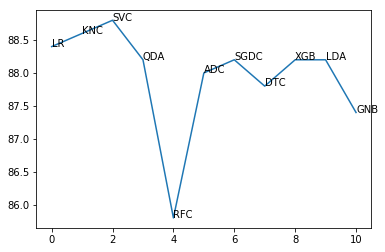

In [39]:
names=['LR','KNC','SVC','QDA','RFC','ADC','SGDC','DTC','XGB','LDA','GNB']
import seaborn as sns
from matplotlib import pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
A = score[:]
plt.plot(A)
for i, label in enumerate(names):
    plt.text(i,A[i], label)
plt.show()